In [2]:
# Base Code
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# STOP
num_return_sequences = 5
max_length = 30



import tiktoken
enc = tiktoken.get_encoding('gpt2')
with open('input.txt', 'r') as f:
    text = f.read()

text = text[:1000]
tokens = enc.encode(text)
B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1])
buf = buf.to(device)
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)

model = GPT(GPTConfig())
model.to(device)

logits = model(x)
print(logits[0].shape)


using device: cuda
torch.Size([4, 32, 50257])


In [3]:
model.transformer.h[0].attn.c_attn.weight.dtype

torch.float32

In [4]:
model.lm_head.weight.dtype

torch.float32

In [5]:
logits[0].dtype

torch.float32

In [1]:
# Add loss
# adding the batch loading part for training
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# STOP
num_return_sequences = 5
max_length = 30



import tiktoken
enc = tiktoken.get_encoding('gpt2')
with open('input.txt', 'r') as f:
    text = f.read()

text = text[:1000]
tokens = enc.encode(text)
B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1])
buf = buf.to(device)
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)

model = GPT(GPTConfig())
model.to(device)

logits, loss = model(x, y)
print(loss) 

using device: cuda
tensor(10.9505, device='cuda:0', grad_fn=<NllLossBackward0>)


In [2]:
print(-torch.log(torch.tensor(1/50257)))

tensor(10.8249)


In [3]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
for i in range(50):
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    print(f'step{i}, loss: {loss.item()}')

step0, loss: 10.950464248657227
step1, loss: 6.575095176696777
step2, loss: 4.192558288574219
step3, loss: 2.5733137130737305
step4, loss: 1.4863554239273071
step5, loss: 0.8406780362129211
step6, loss: 0.46849799156188965
step7, loss: 0.27460557222366333
step8, loss: 0.17047762870788574
step9, loss: 0.11028870940208435
step10, loss: 0.07673893123865128
step11, loss: 0.05782932788133621
step12, loss: 0.04532918334007263
step13, loss: 0.03701532632112503
step14, loss: 0.03173821419477463
step15, loss: 0.027637258172035217
step16, loss: 0.023781869560480118
step17, loss: 0.020386215299367905
step18, loss: 0.017702696844935417
step19, loss: 0.015623477287590504
step20, loss: 0.013946694321930408
step21, loss: 0.01253364235162735
step22, loss: 0.011313318274915218
step23, loss: 0.010254488326609135
step24, loss: 0.009340804070234299
step25, loss: 0.008557592518627644
step26, loss: 0.007887445390224457
step27, loss: 0.00731207150965929
step28, loss: 0.006813973654061556
step29, loss: 0.0063

In [4]:
# Let's make a full dataloadaer

# DATALOADER
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# STOP
num_return_sequences = 5
max_length = 30



import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        # at init load tokens from disk and store them in memory
        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2') 
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T)} batches')

        # state
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position + B * T + 1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B*T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y


model = GPT(GPTConfig())
model.to(device)

train_loader = DataLoaderLite(B = 4, T = 32)

# NEW CODE
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
for i in range(50):
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    print(f'step{i}, loss: {loss.item()}')


print(loss)

using device: cuda
loaded 338025 tokens
1 epoch = 2640 batches
step0, loss: 10.920181274414062
step1, loss: 9.812644958496094
step2, loss: 8.712605476379395
step3, loss: 9.132890701293945
step4, loss: 8.576388359069824
step5, loss: 8.177474975585938
step6, loss: 8.99504280090332
step7, loss: 8.734390258789062
step8, loss: 8.082488059997559
step9, loss: 7.955374717712402
step10, loss: 8.433320045471191
step11, loss: 7.261044025421143
step12, loss: 7.826310157775879
step13, loss: 7.411554336547852
step14, loss: 7.557544708251953
step15, loss: 7.250461578369141
step16, loss: 7.4031829833984375
step17, loss: 8.335494995117188
step18, loss: 7.099075794219971
step19, loss: 7.762372016906738
step20, loss: 7.483112335205078
step21, loss: 7.6350812911987305
step22, loss: 6.20756721496582
step23, loss: 6.624934196472168
step24, loss: 6.600099086761475
step25, loss: 6.21558141708374
step26, loss: 6.268570423126221
step27, loss: 7.402144432067871
step28, loss: 6.884303569793701
step29, loss: 6.645

In [5]:
# Weight sharing
# Weight Sharing
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing
        self.transformer.wte.weight = self.lm_head.weight

        # weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean = 0.0, std = 0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std = 0.02)



    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# STOP
num_return_sequences = 5
max_length = 30



import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        # at init load tokens from disk and store them in memory
        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2') 
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T)} batches')

        # state
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position + B * T + 1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B*T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y


model = GPT(GPTConfig())
model.to(device)

train_loader = DataLoaderLite(B = 4, T = 32)

# NEW CODE
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
for i in range(50):
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    print(f'step{i}, loss: {loss.item()}')


print(loss)

using device: cuda
loaded 338025 tokens
1 epoch = 2640 batches
step0, loss: 10.941183090209961
step1, loss: 9.684093475341797
step2, loss: 8.972075462341309
step3, loss: 9.140128135681152
step4, loss: 8.709209442138672
step5, loss: 8.39765739440918
step6, loss: 8.966639518737793
step7, loss: 8.731046676635742
step8, loss: 8.159562110900879
step9, loss: 7.963054180145264
step10, loss: 8.357766151428223
step11, loss: 7.490817546844482
step12, loss: 7.814469814300537
step13, loss: 7.3949360847473145
step14, loss: 7.5309062004089355
step15, loss: 7.35502290725708
step16, loss: 7.442122459411621
step17, loss: 8.162090301513672
step18, loss: 7.186564922332764
step19, loss: 7.793060302734375
step20, loss: 7.510186672210693
step21, loss: 7.809110164642334
step22, loss: 6.435649394989014
step23, loss: 6.900519847869873
step24, loss: 6.8828582763671875
step25, loss: 6.716039657592773
step26, loss: 6.772925853729248
step27, loss: 7.5470991134643555
step28, loss: 7.1985979080200195
step29, loss: 6

In [6]:
# Residual std scaling issue
# Solving for residual std scaling issue
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing
        self.transformer.wte.weight = self.lm_head.weight

        # weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean = 0.0, std = std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std = 0.02)



    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# SEED
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# STOP
num_return_sequences = 5
max_length = 30



import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        # at init load tokens from disk and store them in memory
        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2') 
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T)} batches')

        # state
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position + B * T + 1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B*T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y


model = GPT(GPTConfig())
model.to(device)

train_loader = DataLoaderLite(B = 4, T = 32)

# NEW CODE
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
for i in range(50):
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    print(f'step{i}, loss: {loss.item()}')


print(loss)


using device: cuda
loaded 338025 tokens
1 epoch = 2640 batches
step0, loss: 11.031367301940918
step1, loss: 9.635494232177734
step2, loss: 8.954357147216797
step3, loss: 9.163911819458008
step4, loss: 8.736703872680664
step5, loss: 8.332362174987793
step6, loss: 8.96406364440918
step7, loss: 8.89919662475586
step8, loss: 8.11715030670166
step9, loss: 8.034951210021973
step10, loss: 8.403307914733887
step11, loss: 7.447668075561523
step12, loss: 7.755180358886719
step13, loss: 7.432129383087158
step14, loss: 7.508581638336182
step15, loss: 7.3706536293029785
step16, loss: 7.445652008056641
step17, loss: 8.286404609680176
step18, loss: 7.155075550079346
step19, loss: 7.8362226486206055
step20, loss: 7.472085952758789
step21, loss: 7.787292957305908
step22, loss: 6.425104141235352
step23, loss: 6.83209753036499
step24, loss: 6.766149520874023
step25, loss: 6.562461853027344
step26, loss: 7.186689376831055
step27, loss: 7.577374458312988
step28, loss: 7.137980937957764
step29, loss: 6.9026

# Speed ups


In [1]:
# First Speed up.. just adding related calculation code
# Solving for residual std scaling issue
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing
        self.transformer.wte.weight = self.lm_head.weight

        # weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean = 0.0, std = std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std = 0.02)



    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# SEED
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# STOP
num_return_sequences = 5
max_length = 30



import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        # at init load tokens from disk and store them in memory
        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2') 
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T)} batches')

        # state
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position + B * T + 1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B*T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y


model = GPT(GPTConfig())
model.to(device)

train_loader = DataLoaderLite(B = 8, T = 1024)

# NEW CODE
import time
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
for i in range(50):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize() 
    t1 = time.time()
    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f'step{i} | loss: {loss.item()} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec: .2f}')


print(loss)


using device: cuda
loaded 338025 tokens
1 epoch = 41 batches
step0 | loss: 10.974886894226074 | dt: 3860.74ms | tok/sec:  2121.87
step1 | loss: 9.438068389892578 | dt: 2208.89ms | tok/sec:  3708.65
step2 | loss: 9.426380157470703 | dt: 2256.86ms | tok/sec:  3629.82
step3 | loss: 8.6160306930542 | dt: 2316.49ms | tok/sec:  3536.39
step4 | loss: 8.432503700256348 | dt: 2347.10ms | tok/sec:  3490.27
step5 | loss: 8.432765007019043 | dt: 2336.24ms | tok/sec:  3506.49
step6 | loss: 8.32859992980957 | dt: 2329.66ms | tok/sec:  3516.39
step7 | loss: 8.0079984664917 | dt: 2306.61ms | tok/sec:  3551.53
step8 | loss: 7.736836910247803 | dt: 2328.86ms | tok/sec:  3517.60
step9 | loss: 7.691933631896973 | dt: 2357.12ms | tok/sec:  3475.42
step10 | loss: 7.659118175506592 | dt: 2346.67ms | tok/sec:  3490.90
step11 | loss: 7.492031574249268 | dt: 2356.98ms | tok/sec:  3475.64
step12 | loss: 7.4290595054626465 | dt: 2379.18ms | tok/sec:  3443.20
step13 | loss: 7.214234352111816 | dt: 2418.43ms | tok/

In [1]:
# we are only going to add 'high'
# torch.set_float32_matmul_precision('high')
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing
        self.transformer.wte.weight = self.lm_head.weight

        # weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean = 0.0, std = std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std = 0.02)



    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# SEED
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# STOP
num_return_sequences = 5
max_length = 30



import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        # at init load tokens from disk and store them in memory
        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2') 
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T)} batches')

        # state
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position + B * T + 1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B*T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y

# CHANGES IN CURRENT CODE
torch.set_float32_matmul_precision('high')

model = GPT(GPTConfig())
model.to(device)

train_loader = DataLoaderLite(B = 8, T = 1024)

# NEW CODE
import time
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
for i in range(50):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    # torch.cuda.synchronize() 
    t1 = time.time()
    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f'step{i} | loss: {loss.item()} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec: .2f}')


print(loss)

# step13 | loss: 7.214234352111816 | dt: 2418.43ms | tok/sec:  3387.32
# step13 | loss: 7.214259624481201 | dt: 1337.68ms | tok/sec:  6124.05

using device: cuda
loaded 338025 tokens
1 epoch = 41 batches
step0 | loss: 10.9749174118042 | dt: 4586.91ms | tok/sec:  1785.95
step1 | loss: 9.438058853149414 | dt: 1279.07ms | tok/sec:  6404.67
step2 | loss: 9.425962448120117 | dt: 1325.97ms | tok/sec:  6178.13
step3 | loss: 8.615828514099121 | dt: 1245.20ms | tok/sec:  6578.86
step4 | loss: 8.43260383605957 | dt: 1301.69ms | tok/sec:  6293.34
step5 | loss: 8.432779312133789 | dt: 1260.57ms | tok/sec:  6498.64
step6 | loss: 8.328548431396484 | dt: 1274.78ms | tok/sec:  6426.19
step7 | loss: 8.008028030395508 | dt: 1272.11ms | tok/sec:  6439.70
step8 | loss: 7.736903190612793 | dt: 1267.27ms | tok/sec:  6464.28
step9 | loss: 7.69196081161499 | dt: 1332.16ms | tok/sec:  6149.43
step10 | loss: 7.659093379974365 | dt: 1338.21ms | tok/sec:  6121.63
step11 | loss: 7.491988182067871 | dt: 1355.79ms | tok/sec:  6042.23
step12 | loss: 7.429058074951172 | dt: 1304.50ms | tok/sec:  6279.80
step13 | loss: 7.214259624481201 | dt: 1337.68ms | tok/

In [1]:

# now we'll add autocast to the forward pass
# Logits and Loss
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing
        self.transformer.wte.weight = self.lm_head.weight

        # weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean = 0.0, std = std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std = 0.02)



    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# SEED
# torch.manual_seed(1337)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(1337)

# STOP
num_return_sequences = 5
max_length = 30



import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        # at init load tokens from disk and store them in memory
        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2') 
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T)} batches')

        # state
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position + B * T + 1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B*T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y

# CHANGES IN CURRENT CODE
torch.set_float32_matmul_precision('high')

model = GPT(GPTConfig())
model.to(device)

train_loader = DataLoaderLite(B = 8, T = 1024)

# NEW CODE
import time
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
for i in range(50):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    # NEW CODE ADDED HERE
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y) 
    loss.backward()
    optimizer.step()
    # torch.cuda.synchronize() 
    t1 = time.time()
    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f'step{i} | loss: {loss.item()} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec: .2f}')


print(loss)

# step13 | loss: 7.214234352111816 | dt: 2418.43ms | tok/sec:  3387.32
# step13 | loss: 7.214259624481201 | dt: 1337.68ms | tok/sec:  6124.05
# step13 | loss: 7.330005645751953 | dt: 978.19ms | tok/sec:  8374.65

using device: cuda
loaded 338025 tokens
1 epoch = 41 batches
step0 | loss: 10.946540832519531 | dt: 3838.33ms | tok/sec:  2134.26
step1 | loss: 9.497331619262695 | dt: 985.99ms | tok/sec:  8308.39
step2 | loss: 10.459564208984375 | dt: 967.06ms | tok/sec:  8471.06
step3 | loss: 9.196014404296875 | dt: 956.78ms | tok/sec:  8562.05
step4 | loss: 8.783353805541992 | dt: 967.49ms | tok/sec:  8467.29
step5 | loss: 8.550586700439453 | dt: 961.14ms | tok/sec:  8523.24
step6 | loss: 8.453838348388672 | dt: 946.04ms | tok/sec:  8659.27
step7 | loss: 8.166803359985352 | dt: 973.36ms | tok/sec:  8416.21
step8 | loss: 7.900913238525391 | dt: 966.09ms | tok/sec:  8479.55
step9 | loss: 7.84703254699707 | dt: 957.49ms | tok/sec:  8555.67
step10 | loss: 7.785855293273926 | dt: 978.80ms | tok/sec:  8369.42
step11 | loss: 7.580438613891602 | dt: 981.27ms | tok/sec:  8348.39
step12 | loss: 7.539167404174805 | dt: 995.78ms | tok/sec:  8226.73
step13 | loss: 7.330005645751953 | dt: 978.19ms | tok/sec:  837

In [2]:
# Next is torch.compile that doesn't work on mac or windows yet
# torch.compile
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)
        # y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal = True) 

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing
        self.transformer.wte.weight = self.lm_head.weight

        # weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean = 0.0, std = std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std = 0.02)



    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# SEED
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# STOP
num_return_sequences = 5
max_length = 30



import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        # at init load tokens from disk and store them in memory
        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2') 
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T)} batches')

        # state
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position + B * T + 1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B*T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y

# CHANGES IN CURRENT CODE
torch.set_float32_matmul_precision('high')

model = GPT(GPTConfig())
model.to(device)
model = torch.compile(model)

train_loader = DataLoaderLite(B = 8, T = 1024)

# NEW CODE
import time
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
for i in range(50):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    # NEW CODE ADDED HERE
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y) 
    loss.backward()
    optimizer.step()
    # torch.cuda.synchronize() 
    t1 = time.time()
    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f'step{i} | loss: {loss.item()} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec: .2f}')


print(loss)

# step13 | loss: 7.214234352111816 | dt: 2418.43ms | tok/sec:  3387.32
# step13 | loss: 7.214259624481201 | dt: 1337.68ms | tok/sec:  6124.05
# step13 | loss: 7.330005645751953 | dt: 978.19ms | tok/sec:  8374.65

using device: cuda


RuntimeError: Windows not yet supported for torch.compile

In [3]:
# Flash Attention
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)
        # y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = F.scaled_dot_product_attention(q, k, v, is_causal = True) # Flash attention

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing
        self.transformer.wte.weight = self.lm_head.weight

        # weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean = 0.0, std = std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std = 0.02)



    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# SEED
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# STOP
num_return_sequences = 5
max_length = 30



import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        # at init load tokens from disk and store them in memory
        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2') 
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T)} batches')

        # state
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position + B * T + 1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B*T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y

# CHANGES IN CURRENT CODE
torch.set_float32_matmul_precision('high')

model = GPT(GPTConfig())
model.to(device)
# model = torch.compile(model)

train_loader = DataLoaderLite(B = 16, T = 1024)

# NEW CODE
import time
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
for i in range(50):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    # NEW CODE ADDED HERE
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y) 
    loss.backward()
    optimizer.step()
    # torch.cuda.synchronize() 
    t1 = time.time()
    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f'step{i} | loss: {loss.item()} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec: .2f}')


print(loss)

# step13 | loss: 7.214234352111816 | dt: 2418.43ms | tok/sec:  3387.32
# step13 | loss: 7.214259624481201 | dt: 1337.68ms | tok/sec:  6124.05
# step13 | loss: 7.330005645751953 | dt: 978.19ms | tok/sec:  8374.65
# step13 | loss: 7.012979507446289 | dt: 1032.97ms | tok/sec:  15861.12


using device: cuda
loaded 338025 tokens
1 epoch = 20 batches
step0 | loss: 10.968460083007812 | dt: 2102.47ms | tok/sec:  7792.75
step1 | loss: 9.277786254882812 | dt: 984.27ms | tok/sec:  16645.76
step2 | loss: 9.362764358520508 | dt: 977.83ms | tok/sec:  16755.52
step3 | loss: 8.810545921325684 | dt: 1007.94ms | tok/sec:  16254.97
step4 | loss: 8.556181907653809 | dt: 1006.36ms | tok/sec:  16280.48
step5 | loss: 8.501791954040527 | dt: 1004.24ms | tok/sec:  16314.90
step6 | loss: 8.319710731506348 | dt: 997.48ms | tok/sec:  16425.39
step7 | loss: 8.10116958618164 | dt: 1020.09ms | tok/sec:  16061.35
step8 | loss: 7.837139129638672 | dt: 1014.12ms | tok/sec:  16155.81
step9 | loss: 7.592104911804199 | dt: 1023.97ms | tok/sec:  16000.48
step10 | loss: 7.407554626464844 | dt: 1026.98ms | tok/sec:  15953.58
step11 | loss: 7.267879486083984 | dt: 1026.57ms | tok/sec:  15959.92
step12 | loss: 7.089778900146484 | dt: 1027.40ms | tok/sec:  15947.03
step13 | loss: 7.012979507446289 | dt: 1032

In [1]:
# POwer of 2
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)
        # y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = F.scaled_dot_product_attention(q, k, v, is_causal = True) # Flash attention

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50304 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing
        self.transformer.wte.weight = self.lm_head.weight

        # weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean = 0.0, std = std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std = 0.02)



    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# SEED
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# STOP
num_return_sequences = 5
max_length = 30



import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        # at init load tokens from disk and store them in memory
        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2') 
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T)} batches')

        # state
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position + B * T + 1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B*T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y

# CHANGES IN CURRENT CODE
torch.set_float32_matmul_precision('high')

model = GPT(GPTConfig())
model.to(device)
# model = torch.compile(model)

train_loader = DataLoaderLite(B = 16, T = 1024)

# NEW CODE
import time
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
for i in range(50):
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    # NEW CODE ADDED HERE
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y) 
    loss.backward()
    optimizer.step()
    # torch.cuda.synchronize() 
    t1 = time.time()
    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1 - t0)
    print(f'step{i} | loss: {loss.item()} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec: .2f}')


print(loss)

# step13 | loss: 7.214234352111816 | dt: 2418.43ms | tok/sec:  3387.32
# step13 | loss: 7.214259624481201 | dt: 1337.68ms | tok/sec:  6124.05
# step13 | loss: 7.330005645751953 | dt: 978.19ms | tok/sec:  8374.65
# step13 | loss: 7.012979507446289 | dt: 1032.97ms | tok/sec:  15861.12
# step13 | loss: 6.9644927978515625 | dt: 1004.06ms | tok/sec:  16317.75


using device: cuda
loaded 338025 tokens
1 epoch = 20 batches
step0 | loss: 10.975273132324219 | dt: 2864.13ms | tok/sec:  5720.41
step1 | loss: 9.234769821166992 | dt: 970.75ms | tok/sec:  16877.62
step2 | loss: 9.308356285095215 | dt: 969.80ms | tok/sec:  16894.27
step3 | loss: 8.818010330200195 | dt: 975.39ms | tok/sec:  16797.31
step4 | loss: 8.566673278808594 | dt: 986.90ms | tok/sec:  16601.50
step5 | loss: 8.494190216064453 | dt: 984.98ms | tok/sec:  16633.76
step6 | loss: 8.315021514892578 | dt: 988.41ms | tok/sec:  16576.05
step7 | loss: 8.09047794342041 | dt: 993.04ms | tok/sec:  16498.75
step8 | loss: 7.825098037719727 | dt: 998.08ms | tok/sec:  16415.45
step9 | loss: 7.591974258422852 | dt: 987.66ms | tok/sec:  16588.64
step10 | loss: 7.371957302093506 | dt: 1018.85ms | tok/sec:  16080.90
step11 | loss: 7.238385200500488 | dt: 1013.84ms | tok/sec:  16160.36
step12 | loss: 7.02282190322876 | dt: 1041.97ms | tok/sec:  15724.14
step13 | loss: 6.9644927978515625 | dt: 1004.06ms 

In [1]:
# Profiling
# Add loss
# adding the batch loading part for training
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")
print("didn't crash yet!")
# STOP
num_return_sequences = 5
max_length = 30



import tiktoken
enc = tiktoken.get_encoding('gpt2')
with open('input.txt', 'r') as f:
    text = f.read()

text = text[:1000]
tokens = enc.encode(text)
B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1])
buf = buf.to(device)
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)

model = GPT(GPTConfig())
model.to(device)

logits, loss = model(x, y)
print(loss) 

using device: cuda
didn't crash yet!
tensor(10.9279, device='cuda:0', grad_fn=<NllLossBackward0>)


In [2]:
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
model = model
inputs = x

with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    model(inputs)

print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))
prof.export_chrome_trace("trace.json")
# chrome://tracing/

---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
               aten::arange         2.33%       1.381ms         4.75%       2.814ms       1.407ms           0 b           0 b       1.00 Kb           0 b             2  
                aten::empty        10.50%       6.218ms        10.50%       6.218ms      45.058us           0 b           0 b      29.65 Mb      29.65 Mb           138  
              aten::resize_         0.75%     446.000us         0.75%     446.000us     148.667us           0 b           0 b     480.50 Kb     480.5

In [4]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    with_flops=True
) as prof:
    model(inputs)

print(prof.key_averages().table(sort_by="flops", row_limit=10))
prof.export_chrome_trace("trace.json")
# chrome://tracing/

---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total KFLOPs  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                aten::addmm        12.08%      10.050ms        14.28%      11.881ms     247.521us      16.915ms        14.22%      22.312ms     464.833us            48  21743271.936  
                   aten::mm         0.16%     136.000us         0.16%     136.000us     136.000us      19.705ms        16.57%      19.705ms      19.705ms             1   9880928.256  
                  aten::bmm         4.63%       3.849ms         4.63%       3.8

# The Memory and Compute Requirement notebook

This notebook is a simple tool to estimate the memory and compute requirements for the solution of the problem. The notebook is divided into two sections: the first one is dedicated to the memory requirements, while the second one is dedicated to the compute requirements.

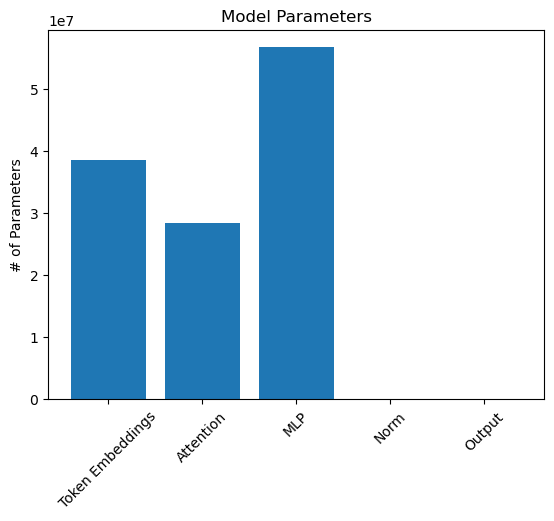

Token Embeddings               38,597,376      31.24%
Attention                      28,311,552      22.91%
MLP                            56,623,104      45.83%
Norm                               19,200       0.02%
Output                                  0       0.00%
Total parameters: 123,551,232


In [5]:
# Some working statistics

# Model
vocabulary_size = 50257
embedding_dimensions = 768
num_attention_heads = 12
num_hidden_layers = 12
feed_forward_ratio = 4

import matplotlib.pyplot as plt

parameter_counts = {
    "Token Embeddings": vocabulary_size * embedding_dimensions,
    "Attention": (
        embedding_dimensions * 3 * embedding_dimensions + embedding_dimensions**2
    ) * num_hidden_layers,
    "MLP": (
        embedding_dimensions * feed_forward_ratio * embedding_dimensions * 2
    ) * num_hidden_layers,
    "Norm": embedding_dimensions * 2 * num_hidden_layers + embedding_dimensions,
    "Output": 0, # We share the embedding weights
}

plt.bar(parameter_counts.keys(), parameter_counts.values())

plt.title("Model Parameters")
plt.ylabel("# of Parameters")
plt.xticks(rotation=45)

plt.show()

total_parameter_count = sum(parameter_counts.values())

for name, count in parameter_counts.items():
    print(f"{name:20s} {count:20,d} {count / total_parameter_count * 100:10.2f}%")


print(f"Total parameters: {total_parameter_count:,}")

To get an idea of the "shape" of our neural network we'll look at the ratio of embeding dimensions to number of layers. Generally, a aspect ratio betweem 50 and 100 is considered optimal according to certain scaling laws (Kaplan et al., 2020).

In [6]:
aspect_ratio = embedding_dimensions / num_hidden_layers

print(f"Network has an aspect ratio of {aspect_ratio:.2f}")

Network has an aspect ratio of 64.00


We can do the same abalysis for the ratio of embedding dimensions to the number of attention heads. A ratio between 20 and 80 is considered optimal according to the same paper.

In [7]:
heads_ratio = embedding_dimensions / num_attention_heads

print(f"Heads ratio is {heads_ratio:.2f}")

Heads ratio is 64.00


Next, we'll estimate the size of the model in memory and on disk. Note that this does not include any intermediate variables that get memorized during training such as activations, gradients, optimizer state, and temporary buffers. Actual memory consumption will likely be much higher. 

In [8]:
bytes_per_parameter = 32 // 8  # Assuming 32-bit floating point

total_bytes = total_parameter_count * bytes_per_parameter

total_gigabytes = total_bytes / 1e9

print(f"Total gigabytes: {total_gigabytes:,.2f}G")

Total gigabytes: 0.49G


We can estimate the optimal number of training tokens using the Chinchilla scaling laws given the number of parameters

In [9]:
num_training_tokens = 20 * total_parameter_count
samples_per_epoch = 512
tokens_per_sample = 2048
num_epochs_required = round(
    num_training_tokens / (samples_per_epoch * tokens_per_sample)
)
print(f"Optimal training tokens: {num_training_tokens:,}")

print(f"Epochs required: {num_epochs_required:,}", end="\n\n")

Optimal training tokens: 2,471,024,640
Epochs required: 2,357



Next, we'll estimate the maximum number of floating point operations (FLOPs) required to perform a full forward pass of the nwtwork on a single sample.

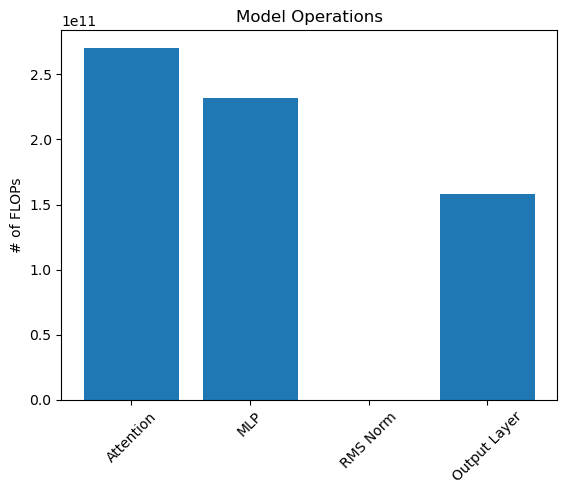

Attention                 270,582,939,648      40.96%
MLP                       231,928,455,168      35.11%
RMS Norm                           69,888       0.00%
Output Layer              158,094,852,096      23.93%


Total forward FLOPs: 660,606,316,800


In [10]:
ops_per_matmul = 2 # Multiply + accumulate (MAC)
# ops_per_activation = 5 # Assuming SiLU
ops_per_activation = 6 # Assuming GeLU
ops_per_rms_norm = 7 # y = x / sqrt(sum(x^2) / n + epsilon) * gamma
head_dimensions = embedding_dimensions // num_attention_heads

# K, Q, V projections
attention = (
    ops_per_matmul
    * tokens_per_sample
    * (embedding_dimensions * 3 * embedding_dimensions)
)

# Attention logits
attention += (
    ops_per_matmul * tokens_per_sample * tokens_per_sample * embedding_dimensions
)

# Reductions
attention += (
    ops_per_matmul
    * num_attention_heads
    * (tokens_per_sample * tokens_per_sample * head_dimensions)
)

# Output projection
attention += ops_per_matmul * tokens_per_sample * embedding_dimensions**2

attention *= num_hidden_layers

# Linear transformations
mlp = (
    ops_per_matmul
    * tokens_per_sample
    * (embedding_dimensions * (4 * embedding_dimensions))
)
mlp += (
    ops_per_matmul
    * tokens_per_sample
    * ((4 * embedding_dimensions) * embedding_dimensions)
)

# Non-linear activations
mlp += ops_per_activation * (4 * embedding_dimensions)

mlp *= num_hidden_layers

rms_norm = ops_per_rms_norm * embedding_dimensions * (num_hidden_layers + 1)

output_layer = (
    ops_per_matmul * tokens_per_sample * embedding_dimensions * vocabulary_size
)

flops = {
    "Attention": attention,
    "MLP": mlp,
    "RMS Norm": rms_norm,
    "Output Layer": output_layer,
}

plt.bar(flops.keys(), flops.values())

plt.title("Model Operations")
plt.ylabel("# of FLOPs")
plt.xticks(rotation=45)

plt.show()

total_forward_flops = sum(flops.values())

for name, count in flops.items():
    print(f"{name:20s} {count:20,d} {count / total_forward_flops * 100:10.2f}%")

print("\n")

print(f"Total forward FLOPs: {total_forward_flops:,}")

Next, we'll estimate the number of FLOPs for the backward pass. For this we use a simple heuristic of 2x the forward pass

In [11]:
total_backward_flops = 2 * total_forward_flops

print(f"Total backward FLOPs: {total_backward_flops:,}")

Total backward FLOPs: 1,321,212,633,600


We'll do the same for the total FLOPs per roundtrip.

In [12]:
total_roundtrip_flops = total_forward_flops + total_backward_flops

print(f"Total roundtrip FLOPs: {total_roundtrip_flops:,}")

Total roundtrip FLOPs: 1,981,818,950,400


Now, let's estimate the number of FLOPs using the method in the PaLM paper by Chowdhery, et al. Then, we'll compare the PaLM estimation with our own as a sanity check.

In [13]:
palm_flops_per_token = (
    6 * total_parameter_count
    + 12 * num_hidden_layers * num_attention_heads * head_dimensions * tokens_per_sample
)

total_palm_flops = palm_flops_per_token * tokens_per_sample

print(f"Total PaLM FLOPs: {total_palm_flops:,}")

Total PaLM FLOPs: 1,982,054,006,784


The two estimates are pretty close so let's proceed.

Finally, let's estimate how long it would take to train over the optimal number of tokens given some common Nvidia Ampere generation GPU hardware configurations. Note that these results shown here are a theoretical scenario and do not factor in additional overhead such as activation checkpointing or network latency.

In [14]:
from dataclasses import dataclass


@dataclass
class Device:
    name: str
    advertised_flops: float
    mfu: float

    @property
    def actual_flops(self) -> float:
        return self.mfu * self.advertised_flops


devices = [
    Device("RTX A2000", 63.9e12, 0.17),
    Device("RTX A4000", 153.4e12, 0.19),
    Device("RTX 3090", 285.5e12, 0.23),
    Device("A100 SXM", 624.0e12, 0.37),
    Device("HGX A100", 4992e12, 0.30),
]

for device in devices:
    seconds_per_epoch = samples_per_epoch * total_roundtrip_flops / device.actual_flops

    days_required = num_epochs_required * seconds_per_epoch / 60 / 60 / 24

    print(
        f"{device.name}: {seconds_per_epoch:.2f} seconds/epoch, {days_required:,.2f} days required"
    )

RTX A2000: 93.41 seconds/epoch, 2.55 days required
RTX A4000: 34.81 seconds/epoch, 0.95 days required
RTX 3090: 15.45 seconds/epoch, 0.42 days required
A100 SXM: 4.39 seconds/epoch, 0.12 days required
HGX A100: 0.68 seconds/epoch, 0.02 days required


# PyTorch LIghtning

In [ ]:
import math
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
import tiktoken
from pytorch_lightning.loggers import TensorBoardLogger

# Dataset
class TextDataset(Dataset):
    def __init__(self, filepath, tokenizer, block_size=1024):
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
        self.tokenizer = tokenizer
        self.block_size = block_size
        self.tokens = tokenizer.encode(text)

    def __len__(self):
        return len(self.tokens) - self.block_size

    def __getitem__(self, idx):
        input_ids = self.tokens[idx:idx + self.block_size]
        target_ids = self.tokens[idx + 1:idx + self.block_size + 1]
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(target_ids, dtype=torch.long)

# Model
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim=768, num_heads=12, num_layers=12, block_size=1024):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(block_size, embed_dim)
        self.layers = nn.ModuleList([
            nn.TransformerDecoderLayer(embed_dim, num_heads, dim_feedforward=4 * embed_dim, activation='gelu')
            for _ in range(num_layers)
        ])
        self.ln = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)
        # weight sharing
        self.token_embedding.weight = self.head.weight

        # weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean = 0.0, std = std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std = 0.02)

    def forward(self, x):
        b, t = x.size()
        positions = torch.arange(t, device=x.device).unsqueeze(0)
        x = self.token_embedding(x) + self.position_embedding(positions)
        for layer in self.layers:
            x = layer(x, x)
        x = self.ln(x)
        return self.head(x)

# Lightning Module
class TransformerLightning(pl.LightningModule):
    def __init__(self, vocab_size, block_size, lr, warmup_steps, max_steps):
        super().__init__()
        self.save_hyperparameters()
        self.model = DecoderOnlyTransformer(vocab_size, block_size=block_size)
        self.criterion = nn.CrossEntropyLoss()
        self.tokenizer = tiktoken.get_encoding("gpt2")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        input_ids, target_ids = batch
        logits = self(input_ids)
        loss = self.criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))
        # Log the loss with 4 decimal precision
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=False, logger=True)
        # Optionally print for observation
        # self.print(f"Train Loss: {loss.item():.4f}")
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

        def lr_lambda(current_step):
            if current_step < self.hparams.warmup_steps:
                return self.hparams.lr * (current_step + 1) / self.hparams.warmup_steps
            elif current_step > self.hparams.max_steps:
                return self.hparams.lr * 0.1
            decay_ratio = (current_step - self.hparams.warmup_steps) / (self.hparams.max_steps - self.hparams.warmup_steps)
            coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
            return self.hparams.lr * 0.1 + coeff * (self.hparams.lr - self.hparams.lr * 0.1)

        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
        return [optimizer], [scheduler]

# Training Script
if __name__ == "__main__":
    # Parameters
    block_size = 768
    batch_size = 16
    max_lr = 6e-4
    warmup_steps = 10
    max_steps = 25000

    tokenizer = tiktoken.get_encoding("gpt2")
    vocab_size = tokenizer.n_vocab

    # Dataset and DataLoader
    dataset = TextDataset("input.txt", tokenizer, block_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model
    model = TransformerLightning(vocab_size, block_size, max_lr, warmup_steps, max_steps)

    torch.set_float32_matmul_precision('high')

    # Set up TensorBoard logger
    logger = TensorBoardLogger("logs/", name="transformer_experiment")
    # tensorboard --logdir logs/
    # create your own theme!
    progress_bar = RichProgressBar(
            refresh_rate=1, 
            leave=False, 
            theme=RichProgressBarTheme(
                description='', 
                progress_bar='#6206E0', 
                progress_bar_finished='#6206E0', 
                progress_bar_pulse='#6206E0', 
                batch_progress='', 
                time='dim', 
                processing_speed='dim underline', 
                metrics='italic', 
                metrics_text_delimiter=' ', 
                metrics_format='.3f'), 
            console_kwargs=None
    )

    # Trainer
    trainer = pl.Trainer(
        max_steps=max_steps,
        accelerator="gpu",
        devices=1,
        callbacks=[LearningRateMonitor(logging_interval='step'), progress_bar],
        precision='bf16-mixed', # 16-bit floating point, many other options are there
        log_every_n_steps=1,
        enable_progress_bar=True, # show progress bar
        enable_model_summary=True, # show model summary
        logger=logger
    )

    # https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.trainer.trainer.Trainer.html
    # Training
    trainer.fit(model, dataloader)


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/transformer_experiment
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model     │ DecoderOnlyTransformer │  152 M │
│ 1 │ criterion │ CrossEntropyLoss       │      0 │
└───┴───────────┴────────────────────────┴────────┘

Trainable params: 152 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 152 M                                                                                                
Total estimated model params size (MB): 610

Output()

i:\Installs\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
